In [2]:
import os
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, spmatrix

from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.lib.optimization.utils.qpsynapses.process import Sparse
from lava.lib.optimization.utils.qpsynapses.model import NcModelSparse
from lava.lib.optimization.solvers.qp.processes import (
    ProjectedGradientNeuronsPIPGeq,
    ProportionalIntegralNeuronsPIPGeq,
)
from lava.lib.optimization.solvers.qp.ncmodels import (
    NcL2ModelPG,
    NcL2ModelPI,
)

# from lava.utils.profiler import Profiler
from lava.utils.loihi2_profiler import (
    Loihi2Power, Loihi2ExecutionTime, Loihi2Activity, Loihi2Memory
)

from lava.magma.compiler.subcompilers.nc.ncproc_compiler import CompilerOptions
CompilerOptions.verbose = True

In [3]:
def ruiz_equilibriation(matrix, iterations):
    m_bar = matrix 
    left_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[0]))
    right_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[1]))
    row_del, col_del = 0, 0
    for i in range(iterations):
        D_l_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=1))))
        if(m_bar.shape[0] != m_bar.shape[1]):
            D_r_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=0))))
        else:
            D_r_inv = D_l_inv
            
        m_bar = D_l_inv@m_bar@D_r_inv
        left_preconditioner = left_preconditioner@D_l_inv
        #right_preconditioner = right_preconditioner@D_r_inv
        row_del = np.max(np.abs(1-np.linalg.norm(m_bar, ord=2, axis=1))) 
    return left_preconditioner, right_preconditioner, m_bar

In [4]:
## Environment variables
%env SLURM=1
%env LOIHI_GEN=N3C1
# %env NXOPTIONS="--print-voltage"
# %env PARTITION=kp
# %env BOARD=ncl-og-06

env: SLURM=1
env: LOIHI_GEN=N3C1


In [5]:
def convert_to_fp(mat, man_bits):
    """Function that returns the exponent, mantissa representation for
    floating point numbers that need to be represented on Loihi. A global exp
    is calculated for the matrices based on the max absolute value in the
    matrix. This is then used to calculate the manstissae in the matrix.

    Args:
        mat (np.float): The input floating point matrix that needs to be
        converted
        man_bits (int): number of bits that the mantissa uses for it's
        representation (Including sign)

    Returns:
        mat_fp_man (np.int): The matrix in
    """
    exp = np.ceil(np.log2(np.max(np.abs(mat)))) - man_bits + 1
    mat_fp_man = (mat // 2**exp).astype(int)
    return mat_fp_man.astype(int), exp.astype(int)

In [10]:
ser_no = "04"
scale_dict = {'01':"small", '02':"medium", '03':"medium_large",'04':"full", '05':"extra_full" }
path = "NeuRIPS_data/anymal_quadruped/"+ser_no+"_anymal_"+scale_dict[ser_no]+"_scale/"
file_list=os.listdir(path)

num_steps = []
tpts = []
for file in sorted(file_list):
    print(file)
    a = np.load(path+file)
    Q, A, p, k = [a[i] for i in a] 
    Q.shape, A.shape, p.shape, k.shape

    pre_mat_Q, _, _ = ruiz_equilibriation(Q, 5)
    Q_pre = pre_mat_Q@Q@pre_mat_Q
    p_pre = pre_mat_Q@p

    pre_mat_A, _, _ = ruiz_equilibriation(A, 5)
    A_pre = pre_mat_A@A@pre_mat_Q
    k_pre = pre_mat_A@k

    # Generate growth schedule for beta
    growth_factor = 2
    growth_index = 3

    # generate decay schedule for alpha
    decay_factor = 0
    decay_index = 100
    decay_interval = 100

    Q_pre_fp_man, Q_pre_fp_exp = convert_to_fp(Q_pre, 8)
    A_pre_fp_man, A_pre_fp_exp = convert_to_fp(A_pre, 8)
    p_pre_fp_man, p_pre_fp_exp = convert_to_fp(p_pre, 24)
    k_pre_fp_man, k_pre_fp_exp = k_pre.astype(int), 0  # vector of zeros

    # Initial learning-rate mantissae
    beta_man = 7
    alpha_man = 160

    # Initial learning-rate exponent
    alpha_exp = -8
    beta_exp = -10

    # Right shifting of the exponent is done in microcode to increase accuracy
    # Use of two ports necessitates first left-shifting in the connection processes
    # and then right-shifting in the neuron microcode
    correction_exp = min(A_pre_fp_exp, Q_pre_fp_exp)

    Q_exp_new, A_exp_new = (
        -correction_exp + Q_pre_fp_exp,
        -correction_exp + A_pre_fp_exp,
    )

    ProjGrad = ProjectedGradientNeuronsPIPGeq(
                shape=(p_pre_fp_man.shape[0],),
                da_exp=correction_exp,
                grad_bias=p_pre_fp_man,
                grad_bias_exp=p_pre_fp_exp,
                alpha=alpha_man,
                alpha_exp=alpha_exp,
                lr_decay_type="indices",
                alpha_decay_params=(decay_index, decay_interval, decay_factor),
            )

    # Neurons for Constraint Checking
    ProInt = ProportionalIntegralNeuronsPIPGeq(
                shape=(k_pre_fp_man.shape[0],),
                da_exp=A_pre_fp_exp,
                thresholds=k_pre_fp_man,
                thresholds_exp=k_pre_fp_exp,
                beta=beta_man,
                beta_exp=beta_exp,
                lr_growth_type="indices",
                beta_growth_params=(growth_index, growth_factor),
            )
            
    dense_Q = Sparse(
        weights=Q_pre_fp_man, weight_exp=Q_exp_new, num_message_bits=24
    )
    dense_A = Sparse(
        weights=A_pre_fp_man,
        num_message_bits=24,
    )
    dense_A_T = Sparse(
        weights=A_pre_fp_man.T, weight_exp=A_exp_new, num_message_bits=24
    )

    # Connection topology
    dense_Q.a_out.connect(ProjGrad.a_in_qc)
    dense_A_T.a_out.connect(ProjGrad.a_in_qc)
    ProjGrad.s_out_qc.connect(dense_A.s_in)
    ProjGrad.s_out_qc.connect(dense_Q.s_in)
    dense_A.a_out.connect(ProInt.a_in)
    ProInt.s_out.connect(dense_A_T.s_in)

    # Control this to increase/decrease solver iterations 
    num_steps = 300*2



    ProjGrad._log_config.level = 20
    exception_proc_model_map = { 
        ProportionalIntegralNeuronsPIPGeq: NcL2ModelPI,
        ProjectedGradientNeuronsPIPGeq: NcL2ModelPG,
        Sparse: NcModelSparse,
    }

    # Instantiate power logger
    runtime_logger = Loihi2ExecutionTime(buffer_size=num_steps, bin_size=1)
    # power_logger = Loihi2Power(num_steps=num_steps)

    # Queue the logger
    callback_fxs = [runtime_logger]
    run_config = Loihi2HwCfg(callback_fxs=callback_fxs, exception_proc_model_map=exception_proc_model_map)


    ProjGrad.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_config)
    # Uncomment for final solutoin readout
    # x_pre = ProjGrad.qp_neuron_state.get().astype(int)
    ProjGrad.stop()
    # print("Constraint Violation is {}".format(np.linalg.norm(A_pre@x_pre)))
    time_series = runtime_logger.execution_time_per_step
    avg_time_per_timestep = runtime_logger.avg_time_per_step
    tpts.append(avg_time_per_timestep)
    print(f'{avg_time_per_timestep=} us')
print(tpts)

mpc_4800_1800.npz
Per core distribution:
----------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Cores |
|--------------------------------------------------------------|
|     207|       1|     193|     310|      96|       0|      25|
|     179|       1|     196|     306|      98|       0|      49|
|--------------------------------------------------------------|
| Total                                               |      74|
----------------------------------------------------------------


/home/amangalo/dev/src/github/dev/frameworks.ai.lava.lava-loihi/.venv/lib/python3.9/site-packages/nxcore/arch/n3b/n3board.py:53: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.54.73.17:36607
INFO:DRV:      Host server up..............Done 0.34s
INFO:DRV:      Mapping chipIds.............Done 0.09ms
INFO:DRV:      Mapping coreIds.............Done 1.92ms
INFO:DRV:      Partitioning neuron groups..Done 0.02s
INFO:DRV:      Mapping axons...............Done 0.06s
INFO:DRV:      Partitioning MPDS...........Done 9.32ms
INFO:DRV:      Compiling Embedded snips....Done 0.33s
INFO:DRV:      Compiling Host snips........Done 0.07ms
INFO:DRV:      Compiling Register Probes...Done 0.12ms
INFO:DRV:      Compiling Spike Probes......Done 0.02ms
INFO:HST:  Args chip=0 cpu=0 /home/amangalo/dev/src/github/dev/frameworks.ai.lava.lava-loihi/.venv/lib/python3.9/site-packages/nxcore/arch/base/pre_execution/../../../../temp/6459b13c-ede0-11ed-b700-b7bcafa0bdbc/launcher_chip0_cpu0.bin --chips=1 --remote-relay=0 
INFO:HST:  Args chip=0 cpu=1 /home/amangalo/dev/src/github/dev/frameworks.ai.lava.lava-loihi/.venv/lib/

/home/amangalo/dev/src/github/dev/frameworks.ai.lava.lava-loihi/.venv/lib/python3.9/site-packages/nxcore/arch/n3b/n3board.py:53: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.54.73.17:33097
INFO:DRV:      Host server up..............Done 0.43s
INFO:DRV:      Mapping chipIds.............Done 0.02ms
INFO:DRV:      Mapping coreIds.............Done 0.37ms
INFO:DRV:      Partitioning neuron groups..Done 0.02s
INFO:DRV:      Mapping axons...............Done 0.06s
INFO:DRV:      Partitioning MPDS...........Done 9.81ms
INFO:DRV:      Compiling Embedded snips....Done 0.33s
INFO:DRV:      Compiling Host snips........Done 0.04ms
INFO:DRV:      Compiling Register Probes...Done 0.07ms
INFO:DRV:      Compiling Spike Probes......Done 0.01ms
INFO:HST:  Args chip=0 cpu=0 /home/amangalo/dev/src/github/dev/frameworks.ai.lava.lava-loihi/.venv/lib/python3.9/site-packages/nxcore/arch/base/pre_execution/../../../../temp/930d0574-ede0-11ed-b700-b7bcafa0bdbc/launcher_chip0_cpu0.bin --chips=1 --remote-relay=0 
INFO:HST:  Args chip=0 cpu=1 /home/amangalo/dev/src/github/dev/frameworks.ai.lava.lava-loihi/.venv/lib/

avg_time_per_timestep=3.69787453437346 us


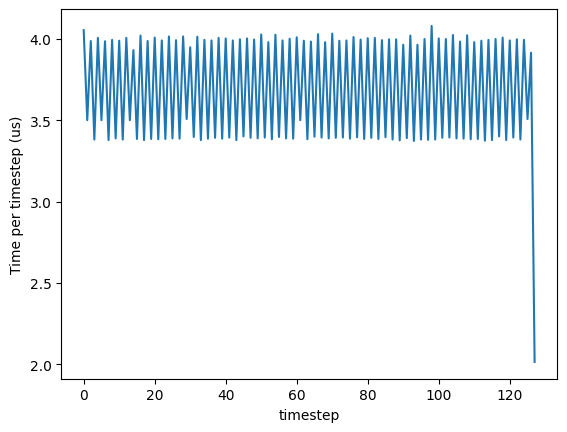

In [7]:
# post processing
time_series = runtime_logger.execution_time_per_step
avg_time_per_timestep = runtime_logger.avg_time_per_step
print(f'{avg_time_per_timestep=} us')

plt.plot(time_series, label='Network Runtime')
plt.ylabel('Time per timestep (us)')
plt.xlabel('timestep')
plt.show()


In [8]:
vdd_p = power_logger.vdd_power  # neurocore power
vddm_p = power_logger.vddm_power  # memory power
vddio_p = power_logger.vddio_power  # IO power
total_power = power_logger.total_power  # Total power

total_power_mean = np.mean(total_power)
vdd_p_mean = np.mean(vdd_p)
vddm_p_mean = np.mean(vddm_p)
vddio_p_mean = np.mean(vddio_p)
# static power
static_total_power = power_logger.static_total_power

print(f'Total Power   : {total_power_mean:.6f} W')
print(f'Dynamic Power : '
        f'{total_power_mean - static_total_power:.6f} W')
print(f'Static Power  : {static_total_power:.6f} W')
print(f'VDD Power     : {vdd_p_mean:.6f} W')
print(f'VDD-M Power   : {vddm_p_mean:.6f} W')
print(f'VDD-IO Power  : {vddio_p_mean:.6f} W')

fig, ax = plt.subplots()
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(total_power, color=color, label='Total Power')
ax.plot(np.zeros_like(total_power)
        + power_logger.static_total_power,
        linestyle='--', color=color, label='Total Static Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vdd_p, color=color, label='VDD Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vddm_p, color=color, label='VDD-M Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vddio_p, color=color, label='VDD-IO Power')
ax.set_ylabel('Power (W)')
ax.set_xticks([])
ax.legend()
plt.show()

NameError: name 'power_logger' is not defined